In [51]:
import paragami
import autograd
import autograd.numpy as np

import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(42)

group_size = 3
num_groups = 10
d = group_size * num_groups

def get_pd_mat(d): 
    a = np.random.random((d, d))
    a = a + a.T + np.eye(d)
    return a

group_mats = np.array([ get_pd_mat(group_size) for g in range(num_groups) ])
pattern = paragami.PatternDict()
pattern['array'] = paragami.NumericArrayPattern((num_groups, group_size))
mat_pattern = paragami.PSDSymmetricMatrixPattern(size=group_size)
pattern['mats'] = paragami.PatternArray((num_groups,), mat_pattern) 

def f(x_dict, w):
    return 0.5 * np.einsum('n,nij,ni,nj',
                           w, x_dict['mats'], x_dict['array'], x_dict['array'])

w = np.ones(num_groups)
x_dict = pattern.random()
f(x_dict, w)

f_flat = paragami.FlattenFunctionInput(
    f, argnums=0, free=True, patterns=pattern)

x_flat = pattern.flatten(x_dict, free=True)
f_flat(x_flat, w)

f_grad = autograd.grad(f_flat, argnum=0)
f_hess = autograd.hessian(f_flat, argnum=0)

hess_time = time.time()
h0 = f_hess(x_flat, w)
hess_time = time.time() - hess_time
print('Hessian time: ', hess_time)

Hessian time:  0.986060380935669


In [5]:
g = 0
x_bool = pattern.empty_bool(False)
x_bool['array'][g, :] = True
x_bool['mats'][g, :, :] = True
pattern.flat_indices(x_bool, free=True)


array([ 0,  1,  2, 30, 31, 32, 33, 34, 35])

In [7]:
inds = []
for g in range(num_groups):
    x_bool = pattern.empty_bool(False)
    x_bool['array'][g, :] = True
    x_bool['mats'][g, :, :] = True
    inds.append(pattern.flat_indices(x_bool, free=True))
inds = np.array(inds)
print('Missing indices: ', np.setdiff1d(np.arange(len(x_flat)), inds.flatten()))
print('Length difference: ', len(x_flat) - len(inds.flatten()))

Missing indices:  []
Length difference:  0


In [8]:
sparse_hess = paragami.SparseBlockHessian(f_flat, inds)
block_hess = sparse_hess.get_block_hessian(x_flat, w)

np.linalg.norm(block_hess - h0)

4.183904711016181e-15

A reverse diff version?

In [14]:
# This works!

from autograd.test_util import check_grads

d = 10
perm = np.random.choice(d, d, replace=False)

x = np.random.random(d)
a = get_pd_mat(d)
def foo(x):
    x_perm = x[perm]
    return np.dot(x_perm, a @ x_perm)

check_grads(foo)(x)

In [17]:
# https://stackoverflow.com/questions/11649577/how-to-invert-a-permutation-array-in-numpy
def invert_permutation(p):
    s = np.empty(p.size, p.dtype)
    s[p] = np.arange(p.size)
    return s

num_blocks = inds.shape[0]
block_size = inds.shape[1]
perm = inds.flatten()
inv_perm = invert_permutation(perm)

def perm_fun(x_block, w_group):
    # This won't work, because each block must be a different value.
    assert len(x_block) == block_size
    x = np.repeat(x_block, num_blocks)
    x_flat = x[inv_perm] 
    return f_flat(x_flat, w_group)
    
x_block = np.random.random(block_size)
fun_wrapper(x_block, w)

check_grads(perm_fun)(x_block, w)


In [27]:
from paragami.sensitivity_lib import _append_jvp
opt_par = x_flat
weights = w

f_grad = autograd.grad(f_flat, argnum=0)
f_fwd_hess = _append_jvp(f_grad, num_base_args=2)

i = 2
v = np.zeros(len(opt_par))
v[i] = 1
print('Should be zero: ', np.linalg.norm(f_fwd_hess(opt_par, weights, v) - h0[i, :]))

Should be zero:  0.0


In [66]:
def hess_summed_term(opt_par, weights, ib):
    """ib = block index
    """
    v = np.zeros_like(opt_par)
    v[inds[:, ib]] = 1
    return f_fwd_hess(opt_par, weights, v)

g1 = 0
hess_prod = hess_summed_term(opt_par, weights, g1)
for g2 in range(num_groups):
    hess_inds = inds[g2, :]
    print(hess_prod[hess_inds] - h0[hess_inds, hess_inds[g1]])

[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.22044605e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 -4.4408921e-16
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [60]:
# hess_split_term = autograd.jacobian(hess_summed_term, argnum=1)
# print(opt_par.shape, weights.shape)
# hsplit = hess_split_term(opt_par, weights, 0)

# This is not necessary

10 9
(90, 10)


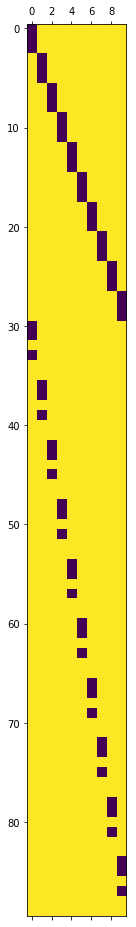

In [59]:
print(num_blocks, block_size)
print(hsplit.shape)
plt.matshow(hsplit == 0)


In [42]:
from scipy.sparse import coo_matrix

mat_vals = [] # These will be the entries of the Hessian
mat_rows = [] # These will be the row indices
mat_cols = [] # These will be the column indices

component_count = 0
for ib in range(block_size):
    print(ib)
    hess_split = hess_split_term(opt_par, weights, ib)
    for b in range(num_blocks):
        mat_vals.extend(hess_split[b, :])
        mat_rows.extend(inds[b, :])
        mat_cols.extend(np.full(block_size, ib))

d = len(opt_par)
h_sparse = coo_matrix((mat_vals, (mat_rows, mat_cols)), (d, d))



0
1
2
3
4
5
6
7
8


ValueError: row, column, and data array must all be the same length